In [1]:
#参考了https://github.com/carlini/nn_robust_attacks/blob/master/l2_attack.py的实现
import numpy as np
from PIL import Image
import tensorflow as tf
import re

from tools import NodeLookup,show_images_diff

In [2]:
#adam的最大迭代次数
max_iterations=10000
#adam学习速率
learning_rate=0.01
#二分查找最大次数
binary_search_steps=10
#c的初始值
initial_const=1e-3
confidence=initial_const

#像素值区间
boxmin = 0.0
boxmax = 255.0

#类别数 tf的实现里面是1008
num_labels=1008

#攻击目标标签 必须使用one hot编码
target_label=288
target_label=np.eye(num_labels)[target_label]


shape = (1,100,100,3)
        
# the variable we're going to optimize over
modifier = tf.Variable(np.zeros(shape,dtype=np.float32))

# these are variables to be more efficient in sending data to tf
timg = tf.Variable(np.zeros(shape), dtype=tf.float32)
tlab = tf.Variable(np.zeros((num_labels)), dtype=tf.float32)
const = tf.Variable(np.zeros([]), dtype=tf.float32)

# the resulting image, tanh'd to keep bounded from boxmin to boxmax
boxmul = (boxmax - boxmin) / 2.
boxplus = (boxmin + boxmax) / 2.
newimg = tf.tanh(modifier + timg) * boxmul + boxplus

In [3]:
#加载解码的图像 这里是个大坑 tf提供的imagenet预训练好的模型pb文件中 包含针对图像的预处理环节 即解码jpg文件 这部分没有梯度
#需要直接处理解码后的数据
session=tf.Session()

def create_graph(dirname):
    with tf.gfile.FastGFile(dirname, 'rb') as f:
        graph_def = session.graph_def
        graph_def.ParseFromString(f.read())

        _ = tf.import_graph_def(graph_def, name='',
                               input_map={"ExpandDims:0":newimg})

#从'http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz'下载并解压到指定路径
create_graph("models/classify_image_graph_def.pb")

# 初始化参数  非常重要
session.run(tf.global_variables_initializer())
tensorlist=[n.name for n in session.graph_def.node]

#print(tensorlist)

#这里注意 一定要查看下当前tensor的名称再写 
softmax_tensor = session.graph.get_tensor_by_name('softmax:0')
#input_tensor=session.graph.get_tensor_by_name('ExpandDims:0')
logits_tensor=session.graph.get_tensor_by_name('softmax/logits:0')
output=logits_tensor

In [4]:
imagename="../picture/cow.jpeg"

image=np.array(Image.open(imagename).convert('RGB').resize((100,100))).astype(np.float32)
#[100,100,3]->[1,100,100,3]
image=np.expand_dims(image, axis=0)

original_img=image.copy()

predictions = session.run(softmax_tensor,
                           {newimg: image})
predictions = np.squeeze(predictions)

# Creates node ID --> English string lookup.
node_lookup = NodeLookup()

#top 3
top_k = predictions.argsort()[-3:][::-1]
for node_id in top_k:
    human_string = node_lookup.id_to_string(node_id)
    score = predictions[node_id]
    print('%s (score = %.5f)(id = %d)' % (human_string, score,node_id))

ox (score = 0.82420)(id = 108)
sorrel (score = 0.04964)(id = 39)
hartebeest (score = 0.02107)(id = 65)


In [5]:
# distance to the input data
l2dist = tf.reduce_sum(tf.square(newimg-(tf.tanh(timg) * boxmul + boxplus)),[1,2,3])

# compute the probability of the label class versus the maximum other
real = tf.reduce_sum((tlab)*output,1)
other = tf.reduce_max((1-tlab)*output - (tlab*10000),1)

loss1 = tf.maximum(0.0, other-real+confidence)

# sum up the losses
loss2 = tf.reduce_sum(l2dist)
loss1 = tf.reduce_sum(const*loss1)
loss = loss1+loss2

optimizer = tf.train.AdamOptimizer(learning_rate)
train_op = optimizer.minimize(loss, var_list=[modifier])


In [6]:
# convert to tanh-space
image = np.arctanh((image - boxplus) / boxmul * 0.999999)

#c的初始化边界
lower_bound = 0
c=initial_const
upper_bound = 1e10

# the best l2, score, and image attack
o_bestl2 = 1e10
o_bestscore = -1
o_bestattack = [np.zeros(shape)]

for outer_step in range(binary_search_steps):
    print("o_bestl2={} confidence={}".format(o_bestl2,confidence)  )
    # completely reset adam's internal state.
    session.run(tf.global_variables_initializer())
    
    session.run(tf.assign(timg, image))
    session.run(tf.assign(tlab, target_label))
    session.run(tf.assign(const, confidence))
    
    for iteration in range(max_iterations):
        # perform the attack 
        _, l, l2, sc, nimg = session.run([train_op, loss, l2dist, output, newimg])
        
        # print out the losses every 10%
        if iteration%(max_iterations//10) == 0:
            print(iteration,session.run((loss,loss1,loss2)))
              
        if (l2 < o_bestl2) and (np.argmax(sc) == np.argmax(target_label)  ):
            print("attack success l2={} target_label={}".format(l2,np.argmax(target_label)))
            o_bestl2 = l2
            o_bestscore = np.argmax(sc)
            o_bestattack = nimg
            
    confidence_old=-1       
    if (o_bestscore == np.argmax(target_label)) and o_bestscore != -1:
        #攻击成功 减小c
        upper_bound = min(upper_bound,confidence)
        if upper_bound < 1e9:
                print()
                confidence_old=confidence
                confidence = (lower_bound + upper_bound)/2
    else:
        lower_bound = max(lower_bound,confidence)
        confidence_old=confidence
        if upper_bound < 1e9:
                confidence = (lower_bound + upper_bound)/2
        else:
                confidence *= 10
                
    print("outer_step={} confidence {}->{}".format(outer_step,confidence_old,confidence))

o_bestl2=10000000000.0 confidence=0.001
0 (30890.96, 0.0061611086, 30890.955)
1000 (0.15800874, 0.010198495, 0.14781025)
2000 (82.7641, 0.010190468, 82.75391)
3000 (22.696735, 0.010196581, 22.686539)
4000 (25.068384, 0.010208418, 25.058176)
5000 (23.625599, 0.010196827, 23.615402)
6000 (25.24465, 0.010191473, 25.234459)
7000 (23.601486, 0.01020124, 23.591286)
8000 (23.804298, 0.010204597, 23.794094)
9000 (24.279045, 0.010207335, 24.268837)
confidence 0.001->0.01
o_bestl2=10000000000.0 confidence=0.01
0 (31989.486, 0.06160874, 31989.424)
1000 (0.11937107, 0.10198353, 0.017387541)
2000 (47.13001, 0.10199272, 47.028015)
3000 (22.923569, 0.10193382, 22.821634)
4000 (24.621988, 0.1019452, 24.520042)
5000 (24.100063, 0.10192671, 23.998137)
6000 (24.235252, 0.101917654, 24.133335)
7000 (23.677252, 0.10184356, 23.575409)
8000 (23.260418, 0.10201564, 23.158401)
9000 (23.834099, 0.101959266, 23.73214)
confidence 0.01->0.1
o_bestl2=10000000000.0 confidence=0.1
0 (32159.146, 0.61609197, 32158.531)

l0=15828 l2=31138.633736887045


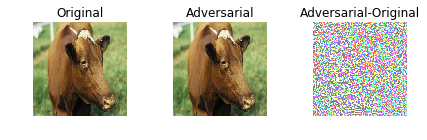

In [7]:
original_img=original_img.astype(np.uint8)
adv_img=o_bestattack.astype(np.uint8)
show_images_diff(original_img[0],0,adv_img[0],0)